"On a uniquement besoin des 8 catégories principales (et non pas des 32 sous-catégories)"

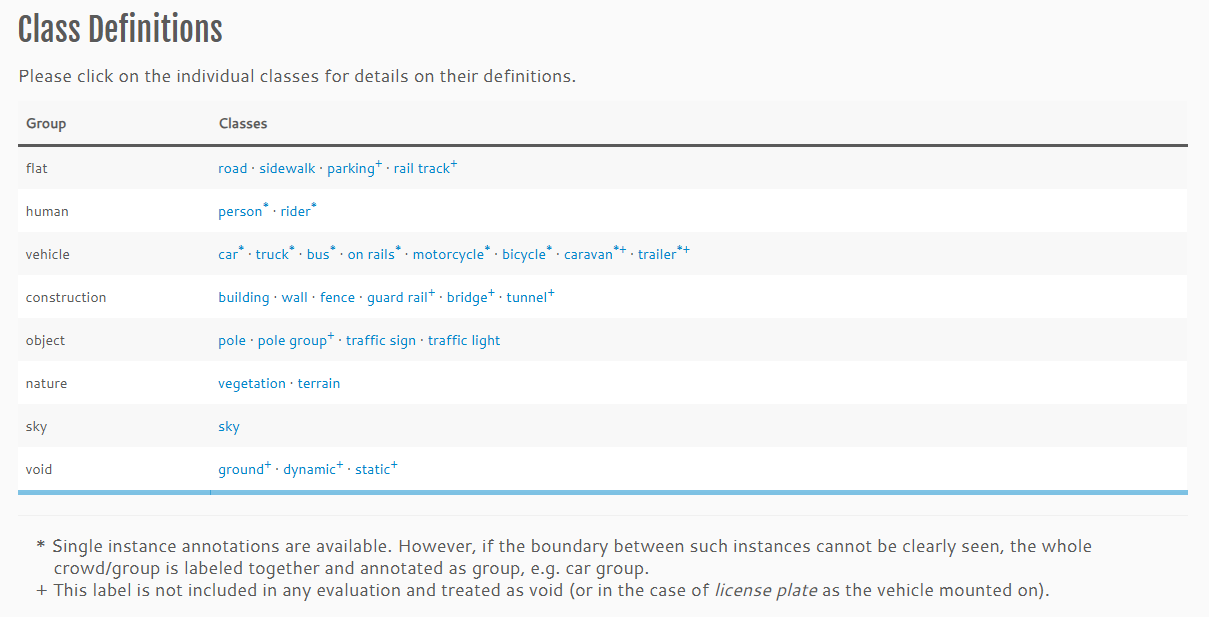

Pour récapituler, vous avez dressé un plan d’action, avec les points suivants :

entraîner un modèle de segmentation des images sur les 8 catégories principales.

Keras est le framework de travail commun à toute l’équipe.

Attention aux contraintes de Franck !

concevoir une API de prédiction (Flask ou FastAPI) qui sera utilisée par Laura et la déployer sur le Cloud (Azure, Heroku, PythonAnywhere ou toute autre solution).

Cette API prend en entrée une image et renvoie le mask prédit (segments prédits de l’image).

concevoir une application web (Flask, Streamlit) de présentation des résultats et la déployer sur le Cloud (Azure, Heroku, PythonAnywhere ou toute autre solution).

Cette application sera l’interface pour tester l’API et afficher les images et masks.

In [1]:
filePath = '/content/drive/MyDrive/Colab Notebooks/Projet 8/P8_Cityscapes_gtFine_trainvaltest/gtFine'

In [10]:
!ls -lR '/content/drive/MyDrive/Colab Notebooks/Projet 8/P8_Cityscapes_gtFine_trainvaltest' | head -100


/content/drive/MyDrive/Colab Notebooks/Projet 8/P8_Cityscapes_gtFine_trainvaltest:
total 7
drwx------ 5 root root 4096 May 26 14:08 gtFine
-rw------- 1 root root 1646 May 26 13:48 license.txt
-rw------- 1 root root  298 May 26 13:48 README

/content/drive/MyDrive/Colab Notebooks/Projet 8/P8_Cityscapes_gtFine_trainvaltest/gtFine:
total 12
drwx------ 2 root root 4096 May 26 14:08 test
drwx------ 2 root root 4096 May 26 14:08 train
drwx------ 2 root root 4096 May 26 14:08 val

/content/drive/MyDrive/Colab Notebooks/Projet 8/P8_Cityscapes_gtFine_trainvaltest/gtFine/test:
total 24
drwx------ 2 root root 4096 May 26 14:08 berlin
drwx------ 2 root root 4096 May 26 14:08 bielefeld
drwx------ 2 root root 4096 May 26 14:08 bonn
drwx------ 2 root root 4096 May 26 14:08 leverkusen
drwx------ 2 root root 4096 May 26 14:08 mainz
drwx------ 2 root root 4096 May 26 14:08 munich

/content/drive/MyDrive/Colab Notebooks/Projet 8/P8_Cityscapes_gtFine_trainvaltest/gtFine/test/berlin:
total 14464
-rw-------

```
/content/drive/MyDrive/Colab Notebooks/Projet 8/P8_Cityscapes_gtFine_trainvaltest/
├── gtFine/
│   ├── train/
│   ├── val/
│   └── test/
│       ├── berlin/
│       │   ├── berlin_XXXX_gtFine_color.png
│       │   ├── berlin_XXXX_gtFine_instanceIds.png
│       │   ├── berlin_XXXX_gtFine_labelIds.png
│       │   └── berlin_XXXX_gtFine_polygons.json
│       └── ...
├── license.txt
├── README
```


*_gtFine_color.png — le mask colorisé (pour la visualisation, pas pour l’entraînement)

*_gtFine_instanceIds.png — segmentation instance-level

*_gtFine_labelIds.png — segmentation pixel-level (chaque pixel = classe, c’est ce qu’il me faut pour l’entraînement !)

*_gtFine_polygons.json — polygones de chaque segment, utile pour certaines tâches avancées, pas pour l’entraînement par mask-image

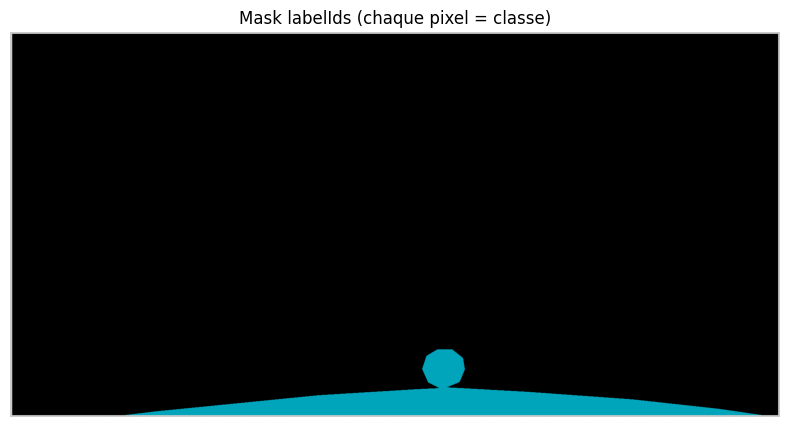

Valeurs uniques présentes dans le mask : [0 1 3]
Shape du mask : (1024, 2048)


In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

mask_path = "/content/drive/MyDrive/Colab Notebooks/Projet 8/P8_Cityscapes_gtFine_trainvaltest/gtFine/test/berlin/berlin_000000_000019_gtFine_labelIds.png"

mask = np.array(Image.open(mask_path))

plt.figure(figsize=(10,5))
plt.title("Mask labelIds (chaque pixel = classe)")
plt.imshow(mask, cmap="nipy_spectral")
plt.axis("off")
plt.show()

print("Valeurs uniques présentes dans le mask :", np.unique(mask))
print("Shape du mask :", mask.shape)


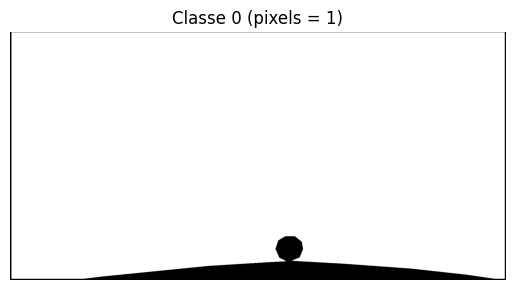

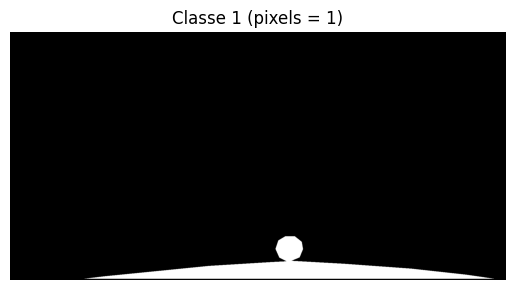

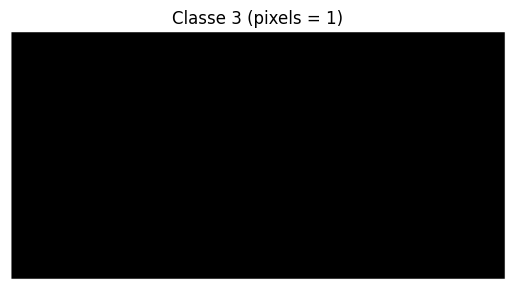

In [12]:
for class_id in np.unique(mask):
    plt.figure()
    plt.title(f"Classe {class_id} (pixels = 1)")
    plt.imshow((mask == class_id).astype(int), cmap='gray')
    plt.axis('off')
    plt.show()


In [13]:
unique, counts = np.unique(mask, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Classe {u}: {c} pixels ({c / mask.size * 100:.4f} %)")


Classe 0: 1983984 pixels (94.6037 %)
Classe 1: 81534 pixels (3.8878 %)
Classe 3: 31634 pixels (1.5084 %)


In [16]:
import os

mask_dir = os.path.join(filePath, "train")  # Remplace par le chemin approprié
classes_presentes = set()

for ville in os.listdir(mask_dir):
    dossier_ville = os.path.join(mask_dir, ville)
    for fichier in os.listdir(dossier_ville):
        if fichier.endswith("labelIds.png"):
            mask = np.array(Image.open(os.path.join(dossier_ville, fichier)))
            classes_presentes.update(np.unique(mask))

print("Valeurs de classes rencontrées :", sorted(list(classes_presentes)))


Valeurs de classes rencontrées : [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12), np.uint8(13), np.uint8(14), np.uint8(15), np.uint8(16), np.uint8(17), np.uint8(18), np.uint8(19), np.uint8(20), np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(24), np.uint8(25), np.uint8(26), np.uint8(27), np.uint8(28), np.uint8(29), np.uint8(30), np.uint8(31), np.uint8(32), np.uint8(33)]


https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

```
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]
```

In [18]:
from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [24]:
labelId_to_superclass = {id_: catId for (_, id_, _, _, catId, _, _, _) in labels}

def mask_to_superclass(mask):
    return np.vectorize(labelId_to_superclass.get)(mask).astype(np.uint8)

print(labelId_to_superclass)

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3, 20: 3, 21: 4, 22: 4, 23: 5, 24: 6, 25: 6, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7, 32: 7, 33: 7, -1: 7}


In [25]:
# Chemins
src_root = filePath
dst_root = filePath + '8'

splits = ['train', 'val', 'test']

for split in splits:

  src_dir = os.path.join(src_root, split)
  dst_dir = os.path.join(dst_root, split)

  os.makedirs(dst_dir, exist_ok=True)

  # Pour chaque ville
  for city in os.listdir(src_dir):
      src_city_dir = os.path.join(src_dir, city)
      dst_city_dir = os.path.join(dst_dir, city)
      os.makedirs(dst_city_dir, exist_ok=True)

      # Pour chaque mask de la ville
      for filename in os.listdir(src_city_dir):
          if filename.endswith("labelIds.png"):
              src_mask_path = os.path.join(src_city_dir, filename)
              dst_mask_path = os.path.join(dst_city_dir, filename)

              mask = np.array(Image.open(src_mask_path))
              # Conversion par mapping
              new_mask = mask_to_superclass(mask)

              # Sauvegarde en PNG
              Image.fromarray(new_mask).save(dst_mask_path)


In [28]:
test_path = "/content/drive/MyDrive/Colab Notebooks/Projet 8/P8_Cityscapes_gtFine_trainvaltest/gtFine8/train/aachen/aachen_000000_000019_gtFine_labelIds.png"
mask = np.array(Image.open(test_path))
print(np.unique(mask))  # Doit afficher seulement des valeurs de 0 à 7


[0 1 2 3 4 5 6 7]


In [29]:
mask_dir = os.path.join(dst_root, "train")  # Remplace par le chemin approprié
classes_presentes = set()

for ville in os.listdir(mask_dir):
    dossier_ville = os.path.join(mask_dir, ville)
    for fichier in os.listdir(dossier_ville):
        if fichier.endswith("labelIds.png"):
            mask = np.array(Image.open(os.path.join(dossier_ville, fichier)))
            classes_presentes.update(np.unique(mask))

print("Valeurs de classes rencontrées :", sorted(list(classes_presentes)))

Valeurs de classes rencontrées : [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7)]
